# G Lookup Table in numpy

TODO: 
- add multi-resolution option
- test optimal size (performance vs accuracy)

In [1]:
from scipy.special import hyp1f1
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def hyp_der_approx(a, b, z, eps=10e-10):
    left_approx  = ( hyp1f1(a, b, z) - hyp1f1(a - eps, b, z) ) / eps
    return left_approx

## 1. G Sampling

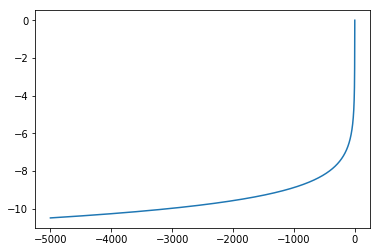

In [3]:
res = 10000
X = np.geomspace(-5000, -1, res) + 1
Y = np.array([hyp_der_approx(0, 0.5, i) for i in X])

plt.plot(X, Y)
plt.show()

In [4]:
table = np.array([X, Y])

In [5]:
np.save('g_lookup_table', table)

## 2. Numpy Lookup Table

In [6]:
def table_lookup(table, key):
    # index from table value with closest table_key to given key
    table_ind = np.argmin( np.abs(table[0] - key) )
    
    # difference from closest table_key to given key
    shift     = key - table[0, table_ind]
    
    # -1 if table_ind == 0, 1 if table_ind > 0 (table ind always >= 0)
    ti_zero_indicator =  - np.sign((1 - np.sign(table_ind)) - .5) 
    
    # shift to next table entry (used for gradient computation)
    # if table_key == key:
    # if key != 0 : next smaller table_key is used
    # if key == 0 : next greater table_key is used
    nonzero_shift = (1 - np.sign(np.absolute(shift))) * (-1. * ti_zero_indicator) + shift
    
    shift_step = np.int(np.sign(nonzero_shift)) 
    table_ind_shifted = table_ind + shift_step
    
    table_val = table[1,table_ind]
    next_table_val = table[1, table_ind_shifted]
    
    table_key = table[0, table_ind]
    next_table_key = table[0, table_ind_shifted]
    
    dx = (next_table_key - table_key)
    dy = (next_table_val - table_val)
    
    gradient               = dy / dx
    interpolated_fun_value = table_val + shift * gradient
    
    return interpolated_fun_value, gradient

### Test: Sin Function

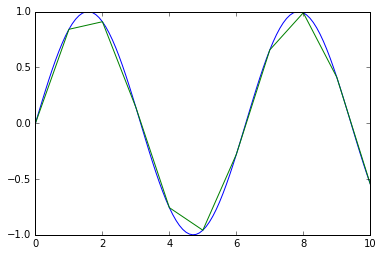

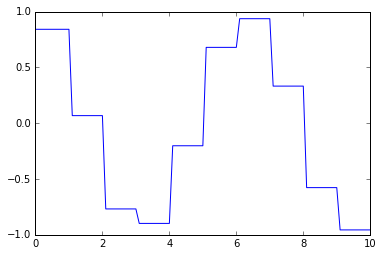

In [7]:
sin_x = np.linspace(0, 10, 11)
sin_y = np.sin(sin_x)
sin_table = np.array([sin_x, sin_y])

grid = np.linspace(0, 10, 101)
vals_grads = np.array([table_lookup(sin_table, x) for x in grid])

plt.plot(grid, np.sin(grid))
plt.plot(grid, vals_grads[:,0])
plt.show()

plt.plot(grid, vals_grads[:,1])
plt.show()

## 3. Tensorflow Lookup Table

In [8]:
def table_lookup_op(table, key):
    # single-lookup only!
    
    # index from table value with closest table_key to given key
    table_ind = tf.argmin( tf.abs(table[0] - key) , output_type=tf.int32)
    
    # difference from closest table_key to given key
    shift     = key - table[0, table_ind]
    
    # -1 if table_ind == 0, 1 if table_ind > 0 (table ind always >= 0)
    ti_zero_indicator = - tf.sign( tf.cast(tf.subtract(1, tf.sign(table_ind)), dtype=tf.float32) - tf.constant(.5))
    
    # shift to next table entry (used for gradient computation)
    # if table_key == key:
    # if key != 0 : next smaller table_key is used
    # if key == 0 : next greater table_key is used
    nonzero_shift = (1 - tf.sign(tf.abs(shift))) * (-1. * ti_zero_indicator) + shift
    
    shift_step = tf.cast(tf.sign(nonzero_shift), tf.int32) 
    table_ind_shifted = table_ind + shift_step
    
    table_val = table[1,table_ind]
    next_table_val = table[1, table_ind_shifted]
    
    table_key = table[0, table_ind]
    next_table_key = table[0, table_ind_shifted]
    
    dx = (next_table_key - table_key)
    dy = (next_table_val - table_val)
    
    gradient               = dy / dx
    interpolated_fun_value = table_val + shift * gradient
    
    return tf.stop_gradient(gradient) * key + tf.stop_gradient(interpolated_fun_value - gradient * key) 

In [50]:
def table_lookup_op_parallel(table, keys):
    
    table_keys = table[0]
    table_vals = table[1]
    
    num_keys = tf.shape(keys)[0]
    
    # index from table value with closest table_key to given key
    table_ind = tf.argmin( tf.abs(tf.expand_dims(table_keys, 0) - tf.expand_dims(keys, 1) ) , output_type=tf.int32, axis=1)
    
    top_keys = tf.gather(table_keys, table_ind)
    
    # difference from closest table_key to given key
    shift     = keys - top_keys
    
    # -1 if table_ind == 0, 1 if table_ind > 0 (table ind always >= 0)
    ti_zero_indicator = - tf.sign( tf.cast(tf.subtract(tf.ones([num_keys], dtype=tf.int32), tf.sign(table_ind)), dtype=tf.float32) - tf.constant(.5))
    
    # shift to next table entry (used for gradient computation)
    # if table_key == key:
    # if key != 0 : next smaller table_key is used
    # if key == 0 : next greater table_key is used
    nonzero_shift = (1 - tf.sign(tf.abs(shift))) * (-1. * ti_zero_indicator) + shift
    
    # nonzero_shift = ( (1 - tf.sign(tf.abs(shift)) * (-1. * ti_zero_indicator) ) + shift )
    
    shift_step        = tf.cast(tf.sign(nonzero_shift), tf.int32) 
    table_ind_shifted = table_ind + shift_step
    
    table_val      = tf.gather(table_vals, table_ind)
    next_table_val = tf.gather(table_vals, table_ind_shifted)
    
    table_key      = tf.gather(table_keys, table_ind)
    next_table_key = tf.gather(table_keys, table_ind_shifted)
    
    dx = (next_table_key - table_key)
    dy = (next_table_val - table_val)
    
    gradient               = dy / dx
    interpolated_fun_value = table_val + shift * gradient
    
    return tf.stop_gradient(gradient) * keys + tf.stop_gradient(interpolated_fun_value - gradient * keys)

### Test: Sin function (comparison to numpy)

Remark: Tensorflows standard type is flat / int 32, therefore the values are less acurate then the ones from numpy

### a) loop

In [13]:
test_values     = np.array([0, 2, 8, 10])
np_lookup_table = [table_lookup(sin_table, x) for x in test_values]

tf_sin_table = tf.convert_to_tensor(sin_table, dtype=tf.float32)
input_x = tf.placeholder(tf.float32, shape=())

table_value = table_lookup_op(tf_sin_table, input_x)
table_grad  = tf.gradients(table_value, [input_x])

with tf.Session() as sess:

    for ind, t_val in enumerate(test_values):
        np_val, np_grad = np_lookup_table[ind]
        tf_val, tf_grad = sess.run([table_value, table_grad[0]], feed_dict={input_x:t_val})
        
        print('np: ')
        print(np_val, np_grad)
        print('tf: ')
        print(tf_val, tf_grad)
        print('\n')
        

np: 
0.0 0.841470984808
tf: 
0.0 0.841471


np: 
0.909297426826 0.0678264420178
tf: 
0.909297 0.0678264


np: 
0.989358246623 0.332371647905
tf: 
0.989358 0.332372


np: 
-0.544021110889 -0.956139596131
tf: 
-0.544021 -0.95614




### b) parallel lookup

In [64]:
test_values     = np.array([0, 2, 8, 10, 11])
np_lookup_table = np.array([table_lookup(sin_table, x) for x in test_values])

tf_sin_table = tf.convert_to_tensor(sin_table, dtype=tf.float32)

input_x = tf.placeholder(tf.float32, shape=[None])

table_values = table_lookup_op_parallel(tf_sin_table, input_x)
table_grads  = tf.gradients(table_values, [input_x])

with tf.Session() as sess:
    
     tf_vals, tf_grads = sess.run([table_values, table_grads[0]], feed_dict={input_x:test_values})
    
print('np')
print(np_lookup_table[:,0])
print(np_lookup_table[:,1])
print('tf')
print(tf_vals)
print(tf_grads)

IndexError: index 11 is out of bounds for axis 1 with size 11